### KOSPI Market with State Space Model

In [64]:
import pandas as pd
import pandas_datareader as pdr
import datetime

start_date = datetime.datetime(2017, 12, 28)
end_date = datetime.datetime(2023, 10, 31)

kospi = pdr.DataReader("KOSPI", "naver", start_date, end_date).astype(float).resample('M').last()
kospi.head()

,Open,High,Low,Close,Volume
Date,,,,,
2017-12-31,2439.31,2467.51,2437.26,2467.49,220336.0
2018-01-31,2557.37,2597.14,2553.01,2566.46,403051.0
2018-02-28,2447.11,2460.12,2426.21,2427.36,367556.0
2018-03-31,2454.10,2458.24,2445.72,2445.85,395329.0
2018-04-30,2502.29,2515.38,2500.22,2515.38,746291.0


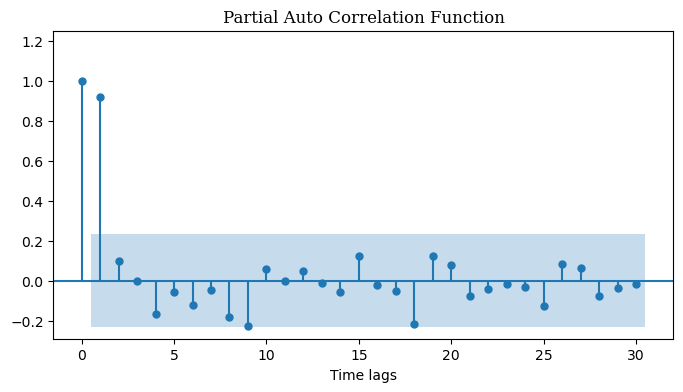

In [65]:
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(figsize = (8, 4))
plot_pacf(np.log(kospi.Close), auto_ylims = True, lags = 30, title = 'PACF of KOSPI log Index', ax = ax)
plt.xlabel('Time lags', fontsize = 10)
plt.title('Partial Auto Correlation Function', fontsize = 12, fontfamily = 'Serif')
plt.show()

In [66]:
ret = np.log(kospi.Close / kospi.Close.shift(1)).dropna()

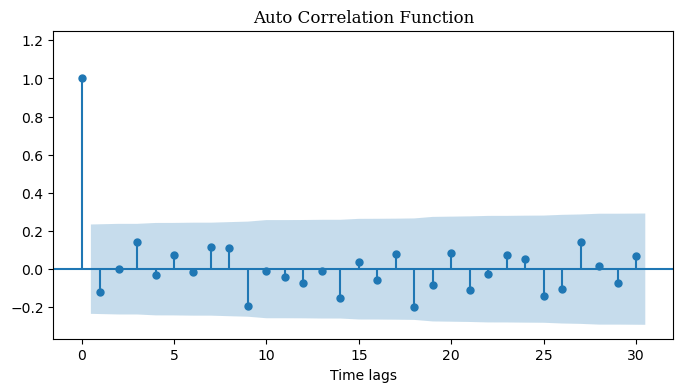

In [67]:
fig, ax = plt.subplots(figsize = (8, 4))
plot_acf(ret, auto_ylims = True, lags = 30, title = 'ACF of KOSPI return' , ax = ax)
plt.xlabel('Time lags', fontsize = 10)
plt.title('Auto Correlation Function', fontsize = 12, fontfamily = 'Serif')
plt.show()

In [70]:
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")
model = sm.tsa.ARIMA(ret, order = (1,0,0), trend = 'c').fit(method = 'innovations_mle')
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                   70
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 101.698
Date:                Thu, 02 Nov 2023   AIC                           -197.395
Time:                        15:46:31   BIC                           -190.650
Sample:                    01-31-2018   HQIC                          -194.716
                         - 10-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0011      0.006     -0.169      0.866      -0.014       0.011
ar.L1         -0.1217      0.112     -1.086      0.277      -0.341       0.098
sigma2         0.0032      0.001      6.164      0.0

AR(1)을 State Space Model로 가정합니다

#### Assumption

$$r_{t+1} = \mu_t + \epsilon_{t+1}, ~~~~~ \epsilon_t ~ \sim ~ N(0, \sigma_\epsilon^2)$$
$$\mu_t = \mu_{t-1} + u_t, ~~~~~ u_t ~ \sim ~ N(0, \sigma_u^2)$$

In [74]:
mu = model.fittedvalues

Text(0.5, 1.0, 'State Space Model with AR(1)')

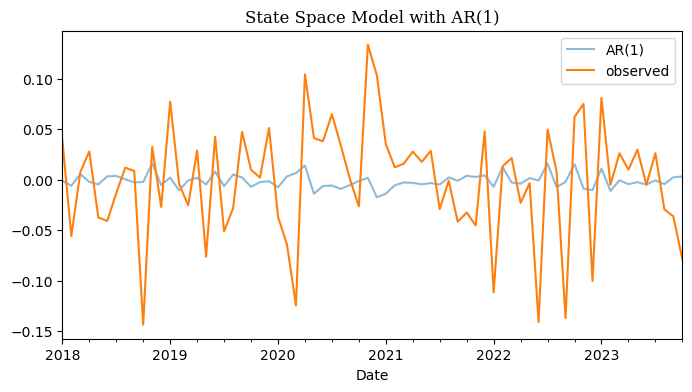

In [85]:
mu.plot(figsize = (8, 4), label = 'AR(1)', alpha = 0.5)
ret.plot(label = 'observed')
plt.legend()
plt.title('State Space Model with AR(1)', fontsize = 12, fontfamily = 'Serif')

In [86]:
ret

Date
2018-01-31    0.039326
2018-02-28   -0.055723
2018-03-31    0.007588
2018-04-30    0.028031
2018-05-31   -0.037413
                ...   
2023-06-30   -0.004995
2023-07-31    0.026287
2023-08-31   -0.029415
2023-09-30   -0.036329
2023-10-31   -0.078927
Freq: M, Name: Close, Length: 70, dtype: float64

$$u_t = \mu_t - (\mu_{t-1} + \mu_{t-2} + \mu_{t-3})$$

In [87]:
model.resid

Date
2018-01-31    0.040410
2018-02-28   -0.049720
2018-03-31    0.002020
2018-04-30    0.030170
2018-05-31   -0.032785
                ...   
2023-06-30   -0.000155
2023-07-31    0.026894
2023-08-31   -0.025000
2023-09-30   -0.038695
2023-10-31   -0.082134
Freq: M, Length: 70, dtype: float64

Text(0.5, 1.0, 'State Space Model with AR(1)')

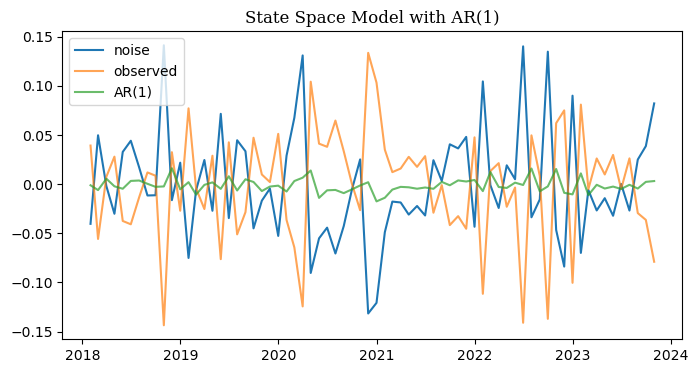

In [100]:
plt.figure(figsize = (8, 4))
plt.plot(-(model.resid - model.resid.mean()), label = 'noise')
plt.plot(ret, label = 'observed', alpha = 0.7)
plt.plot(mu, label = 'AR(1)', alpha = 0.7)
plt.legend()
plt.title('State Space Model with AR(1)', fontsize = 12, fontfamily = 'Serif')

In [101]:
import pandas as pd
matrix = pd.DataFrame([-(model.resid - model.resid.mean()).shift(1), mu, ret], index = ['noise','ar(1)','observed']).T.dropna()
matrix.head()

,noise,ar(1),observed
Date,,,
2018-02-28,-0.040339,-0.006003,-0.055723
2018-03-31,0.049790,0.005569,0.007588
2018-04-30,-0.001950,-0.002139,0.028031
2018-05-31,-0.030100,-0.004628,-0.037413
2018-06-30,0.032856,0.003339,-0.040805


In [102]:
X = matrix[['noise','ar(1)']]
y = matrix['observed']

observed_OLS = sm.OLS(y, X).fit()
print(observed_OLS.summary())

                                 OLS Regression Results                                
Dep. Variable:               observed   R-squared (uncentered):                   0.016
Model:                            OLS   Adj. R-squared (uncentered):             -0.014
Method:                 Least Squares   F-statistic:                             0.5283
Date:                Thu, 02 Nov 2023   Prob (F-statistic):                       0.592
Time:                        15:52:46   Log-Likelihood:                          100.00
No. Observations:                  69   AIC:                                     -196.0
Df Residuals:                      67   BIC:                                     -191.5
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [103]:
X = matrix[['ar(1)']]
y = matrix['observed']

AR_OLS = sm.OLS(y, X).fit()
print(AR_OLS.summary())

                                 OLS Regression Results                                
Dep. Variable:               observed   R-squared (uncentered):                   0.016
Model:                            OLS   Adj. R-squared (uncentered):              0.001
Method:                 Least Squares   F-statistic:                              1.072
Date:                Thu, 02 Nov 2023   Prob (F-statistic):                       0.304
Time:                        15:52:53   Log-Likelihood:                          100.00
No. Observations:                  69   AIC:                                     -198.0
Df Residuals:                      68   BIC:                                     -195.8
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Text(0.5, 1.0, 'State Space Model with AR(3)')

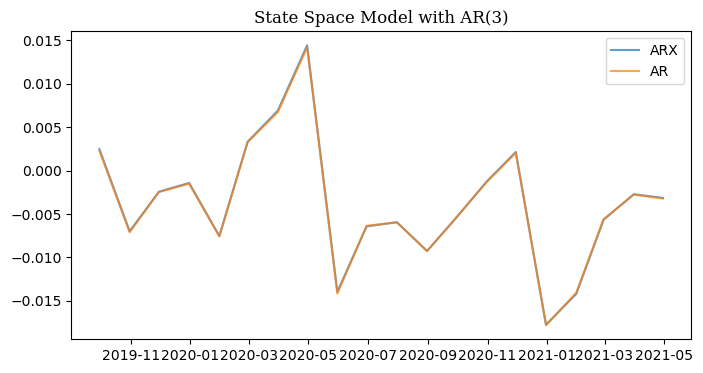

In [96]:
plt.figure(figsize = (8, 4))
plt.plot(observed_OLS.fittedvalues[-50:-30], label = 'ARX', alpha = 0.7)
plt.plot(AR_OLS.fittedvalues[-50:-30], label = 'AR', alpha = 0.7)
#plt.plot(matrix['observed'][-50:-30], label = 'observed')

plt.legend()
plt.title('State Space Model with AR(3)', fontsize = 12, fontfamily = 'Serif')

In [106]:
X1

array([[0.5488135 , 0.71518937, 0.60276338, 0.54488318],
       [0.4236548 , 0.64589411, 0.43758721, 0.891773  ],
       [0.96366276, 0.38344152, 0.79172504, 0.52889492],
       [0.56804456, 0.92559664, 0.07103606, 0.0871293 ],
       [0.0202184 , 0.83261985, 0.77815675, 0.87001215],
       [0.97861834, 0.79915856, 0.46147936, 0.78052918],
       [0.11827443, 0.63992102, 0.14335329, 0.94466892],
       [0.52184832, 0.41466194, 0.26455561, 0.77423369],
       [0.45615033, 0.56843395, 0.0187898 , 0.6176355 ],
       [0.61209572, 0.616934  , 0.94374808, 0.6818203 ],
       [0.3595079 , 0.43703195, 0.6976312 , 0.06022547],
       [0.66676672, 0.67063787, 0.21038256, 0.1289263 ],
       [0.31542835, 0.36371077, 0.57019677, 0.43860151],
       [0.98837384, 0.10204481, 0.20887676, 0.16130952],
       [0.65310833, 0.2532916 , 0.46631077, 0.24442559],
       [0.15896958, 0.11037514, 0.65632959, 0.13818295],
       [0.19658236, 0.36872517, 0.82099323, 0.09710128],
       [0.83794491, 0.09609841,

In [121]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

np.random.seed(0)  # 결과 재현을 위한 시드 설정
X1 = np.random.rand(250, 4)  # 100개의 샘플과 2개의 특성
y1 = (X1[:, 0] + X1[:, 1] > 1).astype(int)  # 레이블 생성 (X의 두 특성을 더한 값이 1보다 크면 1, 아니면 0)

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size = 0.2)

X2 = np.random.rand(250, 5)  # 100개의 샘플과 2개의 특성
y2 = (X2[:, 0] + X2[:, 1] > 1).astype(int)  # 레이블 생성 (X의 두 특성을 더한 값이 1보다 크면 1, 아니면 0)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size = 0.2)

X3 = np.random.rand(250, 3)  # 100개의 샘플과 2개의 특성
y3 = (X3[:, 0] + X3[:, 1] > 1).astype(int)  # 레이블 생성 (X의 두 특성을 더한 값이 1보다 크면 1, 아니면 0)

X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size = 0.2)

model1 = RandomForestClassifier()
model1.fit(X_train1, y_train1)

model2 = RandomForestClassifier()
model2.fit(X_train2, y_train2)

model3 = RandomForestClassifier()
model3.fit(X_train3, y_train3)

RandomForestClassifier()

In [122]:
model1.feature_importances_

array([0.438908  , 0.4522632 , 0.05582607, 0.05300274])

In [123]:
model2.feature_importances_

array([0.36350408, 0.45324774, 0.06067519, 0.05609496, 0.06647804])

In [124]:
model3.feature_importances_

array([0.44644314, 0.42007506, 0.13348179])

In [141]:
from sklearn.metrics import roc_curve, auc, classification_report

# Logistic Regression 모델 예측
y_pred_1 = model1.predict(X_test1)

# Decision Tree 모델 예측
y_pred_2 = model2.predict(X_test2)

# Random Forest 모델 예측
y_pred_3 = model3.predict(X_test3)

# ROC Curve 및 AUC 계산
fpr_1, tpr_1, _ = roc_curve(y_test1, y_pred_1)
roc_auc_1 = auc(fpr_1, tpr_1)

fpr_2, tpr_2, _ = roc_curve(y_test2, y_pred_2)
roc_auc_2 = auc(fpr_2, tpr_2)

fpr_3, tpr_3, _ = roc_curve(y_test3, y_pred_3)
roc_auc_3 = auc(fpr_3, tpr_3)

# Classification Report 출력
print("Model 1:")
print(classification_report(y_test1, y_pred_1))

print("Model 2:")
print(classification_report(y_test2, y_pred_2))

print("Model 3:")
print(classification_report(y_test3, y_pred_3))

Model 1:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        32
           1       0.94      0.94      0.94        18

    accuracy                           0.96        50
   macro avg       0.96      0.96      0.96        50
weighted avg       0.96      0.96      0.96        50

Model 2:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95        30
           1       0.90      0.95      0.93        20

    accuracy                           0.94        50
   macro avg       0.94      0.94      0.94        50
weighted avg       0.94      0.94      0.94        50

Model 3:
              precision    recall  f1-score   support

           0       0.90      0.93      0.91        28
           1       0.90      0.86      0.88        22

    accuracy                           0.90        50
   macro avg       0.90      0.90      0.90        50
weighted avg       0.90      0.90      0.90    

In [142]:
x1 = model1.predict_proba(X_train1)[:,1]
x2 = model2.predict_proba(X_train2)[:,1]
x3 = model3.predict_proba(X_train3)[:,1]

In [143]:
second_model_X = pd.DataFrame([x1,x2,x3], index = ['feature1','feature2','feature3']).T

In [144]:
second_model_X

,feature1,feature2,feature3
0,0.01,0.92,0.02
1,0.98,0.03,0.92
2,1.00,0.01,1.00
3,0.99,0.03,1.00
4,0.94,0.86,0.97
...,...,...,...
195,0.99,1.00,0.04
196,0.13,0.87,0.84
197,0.00,0.09,0.01
198,1.00,0.97,0.96


In [145]:
second_y = (second_model_X['feature1'] + second_model_X['feature2'] > 1).astype(int)  # 레이블 생성 (X의 두 특성을 더한 값이 1보다 크면 1, 아니면 0)

In [146]:
X_train, X_test, y_train, y_test = train_test_split(second_model_X, second_y, test_size = 0.2)

In [147]:
model = RandomForestClassifier()
model.fit(second_model_X, second_y)

RandomForestClassifier()

In [148]:
model.feature_importances_

array([0.57455225, 0.31578831, 0.10965943])

In [149]:
y_pred = model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

In [150]:
print("Secondary Model:")
print(classification_report(y_test, y_pred))

Secondary Model:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00        22

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40
